# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
env_info.vector_observations

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.65278625, -1.5       , -0.        ,  0.        ,
         6.83172083,  6.        , -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.4669857 , -1.5       ,  0.        ,  0.        ,
        -6.83172083,  6.        ,  0.        ,  0.        ]])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


In [7]:
actions = np.random.randn(num_agents, action_size)
actions

array([[-0.66378141,  0.26826919],
       [-0.43405103,  0.79725071]])

In [8]:
actions = np.clip(actions, -1, 1) 
actions

array([[-0.66378141,  0.26826919],
       [-0.43405103,  0.79725071]])

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

The first thing I noticed is in your actor NN model, I would recommend the output be just the tanh() of the final layer, not 10xnormalized tanh(). The output should be between -1.0 and +1.0 and tanh() gives exactly that range of values.

Next, in your OU noise definition, I would recommend reducing sigma to 0.1 or perhaps even 0.05. You can also reduce the scale value over time, multiplying the initial 1.0 value by a constant near one (say, 0.9995, each episode (or, something smaller even if you reduce it each mini-step rather than each episode)



goal: an average score of +0.5 over 100 consecutive episodes, after taking maximim over both agents.

# Another Attempt

In [9]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [10]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1024 # 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class OUNoiseMA:
    """Ornstein-Uhlenbeck process."""

    #def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.05):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBufferMA:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "state_full", "action", "action_full", "reward", "states_array", "next_states_array", "done"])
        self.seed = random.seed(seed)
    
    def add(self, states, states_full, actions, actions_full, rewards, states_array, next_states_array, dones):
        """Add a new experience to memory."""
        e = self.experience(states, states_full, actions, actions_full, rewards, states_array, next_states_array, dones)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        states_full = torch.from_numpy(np.vstack([e.state_full for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        actions_full = torch.from_numpy(np.vstack([e.action_full for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)

        states_array = [e.states_array for e in experiences if e is not None]
        next_states_array = [e.next_states_array for e in experiences if e is not None]
        
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, states_full, actions, actions_full, rewards, states_array, next_states_array, dones) 

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [40]:
class AgentWoCritic():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.num_agent = 2

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Noise process
        self.noise = OUNoiseMA(action_size, random_seed)

    def act(self, state, noise, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()*noise
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        
    def target_act(self, obs_all_agents):
        #"""get target network actions from all the agents in the MADDPG object """
        target_actions = [self.actor_target(torch.from_numpy(np.array(obs)).float().to(device)) for obs in obs_all_agents]

        return target_actions


In [37]:
# main code that contains the neural network setup
# policy + critic updates
# see ddpg.py for other details in the network

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MultiAgentDDPGwCritic:
    def __init__(self, num_agents, state_size, action_size, random_seed=2): #discount_factor=0.95, tau=0.02):
        self.num_agents = num_agents
        self.agents = []
        self.memories = []
        for i in range(num_agents):
            self.memories.append(ReplayBufferMA(action_size, BUFFER_SIZE, BATCH_SIZE, 0))   
            self.agents.append(AgentWoCritic(state_size=state_size, action_size=action_size, random_seed=2))
  
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size*self.num_agents, action_size*self.num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size*self.num_agents, action_size*self.num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoiseMA(action_size, random_seed)

    def act(self, obs_all_agents, noise=0.0):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(obs, noise) for agent, obs in zip(self.agents, obs_all_agents)]
        return actions


    def target_act(self, obs_all_agents):
        #"""get target network actions from all the agents in the MADDPG object """
        target_actions = [self.agents[i].actor_target(torch.from_numpy(np.array(obs_all_agents[i])).float().to(device)) for i in range(len(obs_all_agents))]

        return target_actions


    def update_targets(self):
        """soft update targets"""
        for agent in self.agents:
            soft_update(agent.actor_target, agent.actor_local, self.tau)
            soft_update(agent.critic_target, agent.critic_local, self.tau)

    def step(self, gamma):
        for i in range(self.num_agents):
            experiences = self.memories[i].sample()
            self.learn(self.agents[i], experiences, gamma)
        
    def learn(self, self_agent, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        states, states_full, actions, actions_full, rewards, states_array, next_states_array, dones = experiences

        # ---------------------------- update ALL critics ---------------------------- #
        # Get predicted next-state actions and Q values from target models        
        states_per_agent = np.transpose(states_array,(1,0,2))
        next_states_per_agent = np.transpose(next_states_array,(1,0,2))

        target_actions_array = self.target_act(next_states_per_agent)

        target_actions_full = torch.cat(target_actions_array, dim=1)
        
        states_array = []
        for states in states_per_agent:
            states_array.append(torch.from_numpy(states).float().to(device))
        
        next_states_array = []
        for next_states in next_states_per_agent:
            next_states_array.append(torch.from_numpy(next_states).float().to(device))

        next_states_full = torch.cat(next_states_array, dim=1)
        
        Q_targets_next = self.critic_target(next_states_full, target_actions_full)
        
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss        
        Q_expected = self.critic_local(states_full, actions_full)
        
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        
        critic_loss.backward()

        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        
        # Compute actor loss
        actions_pred_array = []
        for i in range(len(states_array)):
            actions_pred = self.agents[i].actor_local(states_array[i])            
            actions_pred_array.append(actions_pred)
        actions_pred_full = torch.cat(actions_pred_array, dim=1)
        actor_loss = -self.critic_local(states_full, actions_pred_full).mean()
        
        
        # Minimize the loss
        self_agent.actor_optimizer.zero_grad()

        actor_loss.backward()

        self_agent.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        
        self.soft_update(self_agent.actor_local, self_agent.actor_target, TAU)

            
    def save(self):
        for i in range(len(self.agents)):
            torch.save(self.agents[i].actor_local.state_dict(), 'checkpoint_actor{}.pth'.format(i))
        torch.save(self.critic_local.state_dict(), 'checkpoint_critic.pth')

    def reset(self):
        for i in range(len(self.agents)):
            self.agents[i].reset()
    def memory_size(self):
        return len(self.memories[0])

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [38]:
def ma_ddpg(multi_agent, num_agents, n_episodes=1000, max_t=300, print_every=100):
    
    scores_total = []                         # list containing scores from each episode
    try:
        return run_ma_ddpg(multi_agent, num_agents, scores_total, n_episodes, max_t, print_every)
    except KeyboardInterrupt:
        return scores_total

def run_ma_ddpg(multi_agent, num_agents,scores_total, n_episodes=1000, max_t=300, print_every=100):

    scores_window = deque(maxlen=print_every)  # last `print_every`(default:100) times scores 

    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 1
    noise_reduction = 0.9999
    
    max_score = -1
    learning = False
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)

        scores = np.zeros(num_agents) 

        multi_agent.reset()

        while True:
            actions = multi_agent.act(states, noise)

            noise *= noise_reduction
            
            env_info = env.step(actions)[brain_name]    # send all actions to tne environment
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards                  # get reward (for each agent)
            dones = env_info.local_done                 # see if episode finished
            scores += env_info.rewards                  # update the score (for each agent)

            states_full = []
            actions_full = []
            states_array = []
            next_states_array = []
            for i in range(len(states)):
                states_full.extend(states[i])
                actions_full.extend(actions[i])
                states_array.append(states[i])
                next_states_array.append(next_states[i])
        
            for i in range(len(states)):
                multi_agent.memories[i].add(states[i], states_full, actions[i], actions_full, rewards[i], 
                                            states_array, next_states_array, dones[i])
            
            if multi_agent.memory_size() > BATCH_SIZE:
                learning = True
                if i_episode % 20 == 0:
                    for j in range(10):
                        multi_agent.step(GAMMA)

            states = next_states
            if np.any(dones):
                break

        scores_window.append(np.mean(scores))       # save most recent score
        scores_total.append(np.mean(scores))        # save most recent score
        
        print('\rScore (max/min over agents) from episode {}: {:.5f}/{:.5f} - ({:.5f}/{:.5f}) - {}'.format(i_episode, np.max(scores), np.min(scores), np.max(actions), np.min(actions), learning), end="")
        if i_episode % print_every == 0:
            print('\rScore (max/min over agents) from episode {}: {:.5f}/{:.5f} - ({:.5f}/{:.5f}) - {}'.format(i_episode, np.max(scores_window), np.min(scores_window), np.max(actions), np.min(actions), learning))

            if max_score < np.max(scores_window):
                max_score = np.max(scores_window)
                multi_agent.save()
       
    return scores_total

Score (max/min over agents) from episode 20: 0.04500/-0.00500 - (0.18135/0.12094) - False
Score (max/min over agents) from episode 40: 0.09500/-0.00500 - (0.21808/0.07564) - False
Score (max/min over agents) from episode 60: -0.00500/-0.00500 - (1.00000/-0.85378) - True
Score (max/min over agents) from episode 80: -0.00500/-0.00500 - (1.00000/-0.88918) - True
Score (max/min over agents) from episode 100: -0.00500/-0.00500 - (1.00000/-0.86096) - True
Score (max/min over agents) from episode 120: -0.00500/-0.00500 - (1.00000/-0.88929) - True
Score (max/min over agents) from episode 140: -0.00500/-0.00500 - (1.00000/-0.88233) - True
Score (max/min over agents) from episode 160: -0.00500/-0.00500 - (1.00000/-0.86589) - True
Score (max/min over agents) from episode 180: -0.00500/-0.00500 - (1.00000/-0.91196) - True
Score (max/min over agents) from episode 200: -0.00500/-0.00500 - (1.00000/-0.89787) - True
Score (max/min over agents) from episode 220: -0.00500/-0.00500 - (1.00000/-0.92125) -

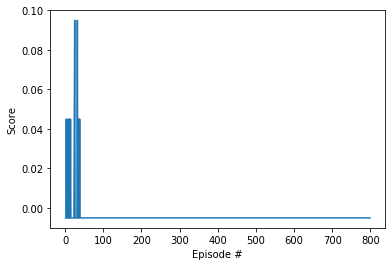

In [44]:
multi_agent = MultiAgentDDPGwCritic(num_agents, state_size, action_size)

#4. Increase max_t from 300 to 1,000only_memories
scores = ma_ddpg(multi_agent, num_agents, n_episodes=3000, max_t=3000, print_every=20)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!
In the next code cell, you will load the trained weights from file to watch a smart agent!

In [42]:
def watch_agent(agent):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)
        
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [43]:
multi_agent = MultiAgentDDPGwCritic(num_agents, state_size, action_size)
multi_agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
for i in range(len(multi_agent.agents)):
    multi_agent.agents[i].actor_local.load_state_dict(torch.load('checkpoint_actor{}.pth'.format(i)))
watch_agent(multi_agent)

Total score (averaged over agents) this episode: -0.004999999888241291


In [ ]:

env.close()